# Modelo de previsão de diabetes 

![diabetes](files/img/header.jpeg)

## Introdução

Esse projeto tem como objetivo prever o diagnóstico de diabetes de um paciente dado um conjunto de dados de saúde. Temos então um problema de **classificação supervisionado**.


## Sobre os dados


Os dados são originalmente do estudo do *National Institute of Diabetes and Digestive and Kidney Diseases* e foram discutidos [neste artigo](http://). Os dados podem ser encontrados [aqui](https://www.kaggle.com/datasets/mathchi/diabetes-data-set). Todos os dados são de pacientes mulheres de pelo menos 21 anos de idade. As *features* são:

* Pregnancies: Número de eventos de gravidez; 
* Glucose: Concentração de glicose plasmática;
* BloodPressure: Pressão sanguínea diastólica ($mmHg$);
* SkinThickness: Grossura da dobra da pele do tríceps ($mm$);
* Insulin: Insulina sérica ($\mu U/mL$);
* BMI: *Body mass index*, Peso em $kg$ / (altura em $m$)$^2$;
* DiabetesPedigreeFunction: mede a possibilidade de diabetes dado o histórico familiar;
* Age: Idade (anos);
* Outcome: Target, 0 para não-diabético, 1 para diabético.



## Problema de negócio e avaliação do modelo

O custo de exame e de prevenção são significativamente menores que os custos de tratamento da diabetes. Além disso, a detecção precoce facilita o tratamento (https://www.previva.com.br/reduzir-custo-do-diabetes/).

Considerando essas informações, a métrica que utilizaremos para avaliar o modelo será o **recall**, uma vez que queremos diagnosticar o máximo de pacientes, ainda que perdendo precisão. Compararemos nossos resultados com um modelo empírico baseado na concentração de glicose. 

Utilizaremos os seguintes dados fictícios para simular o gasto público: o custo de tratamento é de $R\$$ 200/paciente x mês, enquanto o custo de exame/prevenção é de $R\$$ 50,00 / paciente x mês.

## Importando e explorando os dados

In [737]:
# Importando bibliotecas

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, QuantileTransformer
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

In [738]:
data = pd.read_csv("data/diabetes.csv")

In [739]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [740]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [741]:
# Checando duplicados

data.duplicated().sum()

0

In [742]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Não que seja necessário nesse caso, mas podemos reduzir o uso de memória alterando os dtypes.

In [743]:
int_cols = list(data.select_dtypes('int64').columns) 
float_cols = list(data.select_dtypes('float64').columns)

for col in int_cols:
    data[col] = data[col].astype('int16')   # Não temos valores fora de [-32767, +32767]
    
for col in float_cols:
    data[col] = data[col].astype('float32') # 32bits é suficiente para precisão que temos

In [744]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int16  
 1   Glucose                   768 non-null    int16  
 2   BloodPressure             768 non-null    int16  
 3   SkinThickness             768 non-null    int16  
 4   Insulin                   768 non-null    int16  
 5   BMI                       768 non-null    float32
 6   DiabetesPedigreeFunction  768 non-null    float32
 7   Age                       768 non-null    int16  
 8   Outcome                   768 non-null    int16  
dtypes: float32(2), int16(7)
memory usage: 16.6 KB


Tivemos uma redução significativa de uso de memória.

In [745]:
# Checando valores nulos

for col in data.columns:
    print(f"{data[col].eq(0).sum()} valores nulos ({100*data[col].eq(0).sum()/data.shape[0]:.1f} %) em {col}.")

111 valores nulos (14.5 %) em Pregnancies.
5 valores nulos (0.7 %) em Glucose.
35 valores nulos (4.6 %) em BloodPressure.
227 valores nulos (29.6 %) em SkinThickness.
374 valores nulos (48.7 %) em Insulin.
11 valores nulos (1.4 %) em BMI.
0 valores nulos (0.0 %) em DiabetesPedigreeFunction.
0 valores nulos (0.0 %) em Age.
500 valores nulos (65.1 %) em Outcome.


Valores nulos de `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin` e `BMI` são na verdade dados faltantes (NaN). A coluna `Insulin` possui uma quantidade significativa de NaN.

Vamos inspecionar um pouco mais as colunas de Glucose e BMI:

In [746]:
# NaN em Glucose

data[data["Glucose"] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.700001,0.140,22,0
182,1,0,74,20,23,27.700001,0.299,21,0
342,1,0,68,35,0,32.000000,0.389,22,0
349,5,0,80,32,0,41.000000,0.346,37,1
502,6,0,68,41,0,39.000000,0.727,41,1


In [747]:
# NaN em BMI

data[data["BMI"] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
9,8,125,96,0,0,0.0,0.232,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
81,2,74,0,0,0,0.0,0.102,22,0
145,0,102,75,23,0,0.0,0.572,21,0
371,0,118,64,23,89,0.0,1.731,21,0
426,0,94,0,0,0,0.0,0.256,25,0
494,3,80,0,0,0,0.0,0.174,22,0
522,6,114,0,0,0,0.0,0.189,26,0
684,5,136,82,0,0,0.0,0.640,69,0


Um número grande de instâncias que tem valor nulo em `BMI` são de pacientes não-diabéticos. Existem poucas instâncias nulas em `Glucose` e são relativamente homogêneas.

## EDA (Análise exploratória de dados)

Aqui vamos plotar alguns gráficos para verificar a distribuição das varíaveis. Optei por retirar os dados nulos do plot para facilitar a visualização.

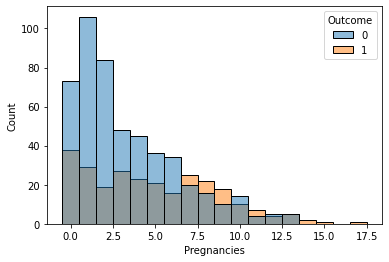

In [748]:
_ = sns.histplot(data, x="Pregnancies", hue="Outcome", discrete=True)

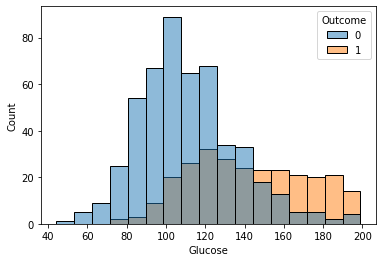

In [749]:
_ = sns.histplot(data[data["Glucose"] != 0], x="Glucose", hue="Outcome")

In [750]:
# Algumas métricas separadas para outcomes

data.loc[data['Glucose'] > 0,['Outcome', 'Glucose']].groupby('Outcome').describe()

Glucose                                                         
          count        mean        std   min    25%    50%    75%    max
Outcome                                                                 
0         497.0  110.643863  24.776906  44.0   93.0  107.0  125.0  197.0
1         266.0  142.319549  29.599199  78.0  119.0  140.0  167.0  199.0

As médias são razoavelmente diferentes, mas os desvios são relativamentos próximos.

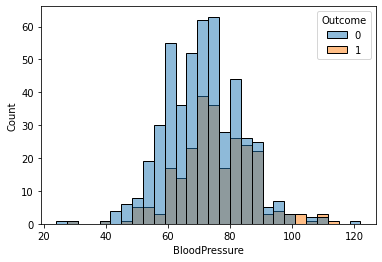

In [751]:
_ = sns.histplot(data[data["BloodPressure"] != 0], x="BloodPressure", hue="Outcome")

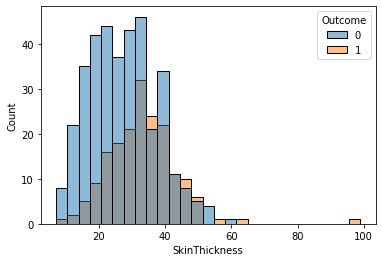

In [752]:
_ = sns.histplot(data[data["SkinThickness"] != 0], x="SkinThickness", hue="Outcome")

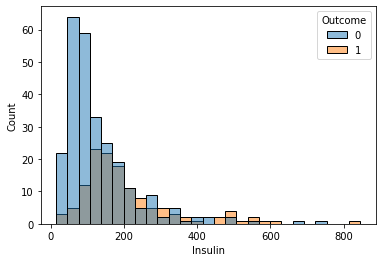

In [753]:
_ = sns.histplot(data[data["Insulin"] != 0], x="Insulin", hue="Outcome")

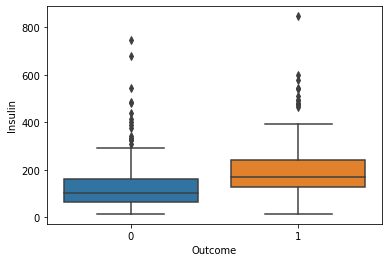

In [754]:
_ = sns.boxplot(data=data[data["Insulin"] != 0], x="Outcome", y="Insulin")

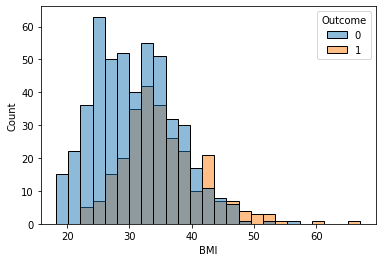

In [755]:
_ = sns.histplot(data[data["BMI"] != 0], x="BMI", hue="Outcome")

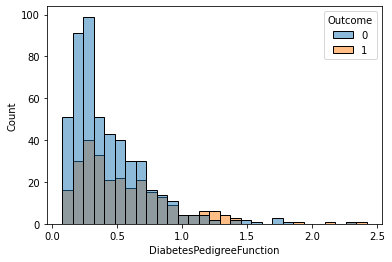

In [756]:
_ = sns.histplot(data, x="DiabetesPedigreeFunction", hue="Outcome")

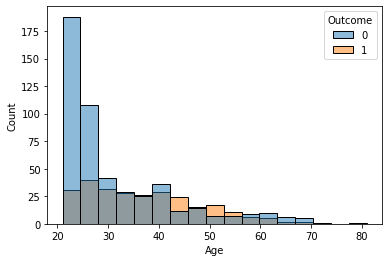

In [757]:
_ = sns.histplot(data, x="Age", hue="Outcome")

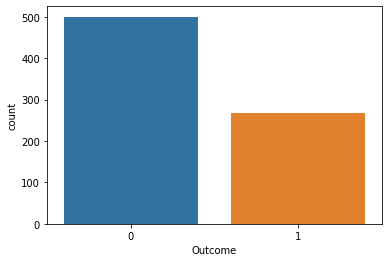

In [758]:
sns.countplot(x=data['Outcome']);

In [759]:
# Percentual dos outcomes
data['Outcome'].value_counts(normalize=True)

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


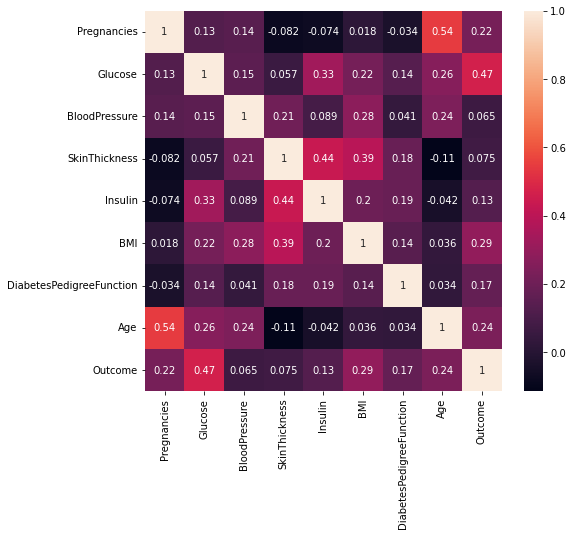

In [760]:
def correlacao(data):
    corr_matrix = data.corr()
    print(corr_matrix["Outcome"].sort_values(ascending=False))   

correlacao(data)

plt.figure(figsize=(8,7))
_ = sns.heatmap(data=data.corr(), annot=True)

A partir da EDA podemos concluir que nossa *target* `Outcome` é suficientemente balanceada e é bem correlacionada com `Glucose`, `BMI`, `Age` e `Preganancies`. Entretanto, parece já existir uma dependência entre `Age` e `Preganancies`. Também parece haver algum grau de codepêndencia entre `SkinThickness`, `BMI` e `Insulin`.

## Redifinindo dados faltantes e separação treino/teste

A partir de agora corrigiremos os valores nulos por NaN e reservaremos nosso dataset de teste para o final.

In [761]:
# Vamos substituir 0 por NaN

data_nan = data.copy()

cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols:
    data_nan[col] = data_nan[col].replace(0, np.nan)

data_nan.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.599998,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.600000,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.299999,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.100000,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.099998,2.288,33,1


In [762]:
data_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int16  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float32
 6   DiabetesPedigreeFunction  768 non-null    float32
 7   Age                       768 non-null    int16  
 8   Outcome                   768 non-null    int16  
dtypes: float32(2), float64(4), int16(3)
memory usage: 34.6 KB


As colunas que tinham NaN viram floats uma vez que esse tipo de dado não é suportado por integers.

In [763]:
# Separação de features e targets
X = data_nan.drop('Outcome', axis=1)
y = data_nan['Outcome']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, stratify=y, random_state=42)

## Modelo de referência

Nosso modelo heurístico é baseado no fato que a taxa de glicose deve ser o parâmetro mais importante para determinar se um paciente é diabético. Dito isto, vamos tentar achar um valor ideal de `Glucose` que nos dê o melhor resultado.

In [764]:
# Criar um X,y para modelo de referência, dropando os NaNs

filtro_nan = X_train['Glucose'].isna()
index_nan = X_train[filtro_nan].index.tolist()

X_train_heuristic = X_train[['Glucose']].drop(index=index_nan)
y_train_heuristic = y_train.drop(index=index_nan)

In [765]:
# Treinando o modelo

glucose_thr = np.arange(62, 198, 1)
accuracy_list = []
recall_list = []
precision_list = []

def test_glucose(gl, thr):
    if gl >= thr:
        return 1
    else:
        return 0
    
for thr in glucose_thr:
    outcome_predict = X_train_heuristic["Glucose"].apply(test_glucose, thr=thr)
    
    accuracy = np.round(accuracy_score(y_train_heuristic, outcome_predict), 4)
    precision = np.round(precision_score(y_train_heuristic, outcome_predict), 4)
    recall = np.round(recall_score(y_train_heuristic, outcome_predict), 4)
    
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)

Utilizaremos o cruzamento entre precision e recall: ainda conservamos um bom recall, temos um alguma precisão e estamos um bom ponto de acurácia.

In [766]:
idx = np.where(np.isclose(np.array(precision_list), np.array(recall_list), rtol=4e-2))[0][0]
thr_heuristic = glucose_thr[idx]
train_recall = recall_list[idx]
train_precision = precision_list[idx]
train_accuracy = accuracy_list[idx]

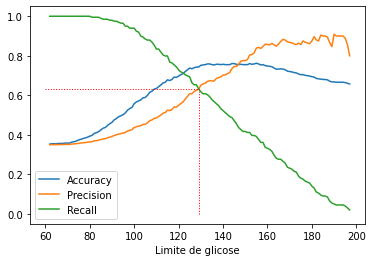

In [767]:
plt.plot(glucose_thr, accuracy_list, label='Accuracy')
plt.plot(glucose_thr, precision_list, label='Precision')
plt.plot(glucose_thr, recall_list, label='Recall')
plt.hlines(y=train_recall, xmin=60, xmax=thr_heuristic, linestyle=':', linewidth=1, color='r')
plt.vlines(x=thr_heuristic, ymin=0.0, ymax=train_recall, linestyle=':', linewidth=1, color='r')
plt.xlabel("Limite de glicose")
plt.legend()
plt.show()

In [768]:
# Print das métricas de treino

print("Métricas de treino:")
print(f"Acurácia: {train_accuracy}")
print(f"Precisão: {train_precision}")
print(f"Recall: {train_recall}")

Métricas de treino:
Acurácia: 0.743
Precisão: 0.63
Recall: 0.6332


Finalmente, vamos avaliar o modelo com os dados de teste. Essas métricas serão uma das nossas referências para avaliar a performace no final.

In [769]:
# Removendo NaN do teste

filtro_nan = X_test['Glucose'].isna()
index_nan = X_test[filtro_nan].index.tolist()

X_test_heuristic = X_test[['Glucose']].drop(index=index_nan)
y_test_heuristic = y_test.drop(index=index_nan)

In [770]:
# Predict no dataset de teste

outcome_predict = X_test_heuristic["Glucose"].apply(test_glucose, thr=thr_heuristic)

accuracy = np.round(accuracy_score(y_test_heuristic, outcome_predict), 4)
precision = np.round(precision_score(y_test_heuristic, outcome_predict), 4)
recall = np.round(recall_score(y_test_heuristic, outcome_predict), 4)

print("Métricas de teste:")
print(f"Acurácia: {accuracy}")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")

Métricas de teste:
Acurácia: 0.712
Precisão: 0.5833
Recall: 0.6269


Ao final também iremos comparar a matriz de confusão:

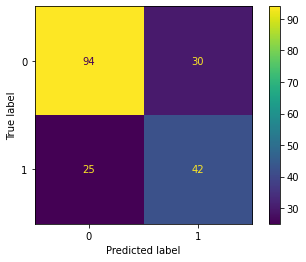

In [771]:
# Matriz de confusão para o modelo heurístico

cm_heuristic = confusion_matrix(y_test_heuristic, outcome_predict)
ConfusionMatrixDisplay(cm_heuristic).plot();

# Baseline ML

Começaremos aqui a construir um modelo simples de machine learning que sirva de baseline. Faremos o mínimo tratamento dos dados ou otimizações nos modelos no momento. Utilizaremos **validação cruzada** uma vez que temos poucas instâncias no dataset e reservaremos o dataset de teste para a avaliação final.

In [772]:
# Definindo uma função para avaliar os modelos com validação cruzada

def relatorio_cross_val(estimator, X_train, y_train):
    """Calcula acurácia, precisão e recall utilizando cross validation"""
    
    cv_accuracy_score = cross_val_score(estimator, X_train, y_train, cv=5, scoring="accuracy")
    cv_precision_score = cross_val_score(estimator, X_train, y_train, cv=5, scoring="precision")
    cv_recall_score = cross_val_score(estimator, X_train, y_train, cv=5, scoring="recall")
    
    cv_accuracy_mean_score = cv_accuracy_score.mean()
    cv_accuracy_std_score = cv_accuracy_score.std()
    
    cv_precision_mean_score = cv_precision_score.mean()
    cv_precision_std_score = cv_precision_score.std()
    
    cv_recall_mean_score = cv_recall_score.mean()
    cv_recall_std_score = cv_recall_score.std()
    
    print(f"Acurácia média: {np.round(cv_accuracy_mean_score, 4)} (std={np.round(cv_accuracy_std_score, 4)})")
    print(f"Precisão média: {np.round(cv_precision_mean_score, 4)} (std={np.round(cv_precision_std_score, 4)})")
    print(f"Recall médio: {np.round(cv_recall_mean_score, 4)} (std={np.round(cv_recall_std_score, 4)})")

In [773]:
# Voltando os NaNs para zero

X_train_fillna = X_train.fillna(0)

Começaremos com uma *decision tree* para ganhar algum insight sobre os dados:

In [774]:
# Decision tree

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_train_fillna, y_train)

relatorio_cross_val(tree_clf, X_train_fillna, y_train)

Acurácia média: 0.7449 (std=0.0242)
Precisão média: 0.7246 (std=0.1252)
Recall médio: 0.4971 (std=0.1058)


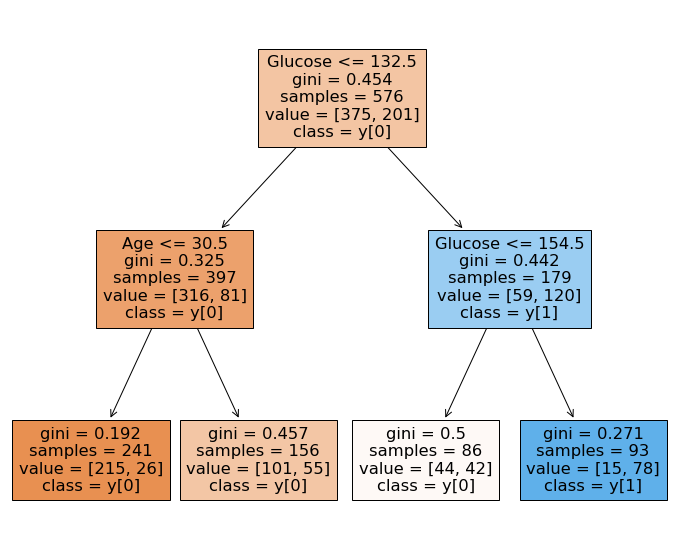

In [775]:
# Plotando árvore

fig = plt.figure(figsize=(12,10))
_ = tree.plot_tree(tree_clf, 
                   feature_names=X_train.columns,  
                   class_names=True,
                   filled=True)

Mesmo com uma árvore simples, já temos uma acurácia média de 74,49%. Também confirmamos algumas expectativas: `Glucose`, `Age` e `BMI` são variáveis importantes nesse problema.

Também podemos treinar uma regressão logística, já que nem todas as features entraram na decision tree. Nesse caso, precisamos normalizar os dados.

In [776]:
# Regressão logística

log_clf = LogisticRegression()

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_fillna)

log_clf.fit(X_train_sc, y_train)
relatorio_cross_val(log_clf, X_train_sc, y_train)

Acurácia média: 0.7796 (std=0.0182)
Precisão média: 0.7326 (std=0.0562)
Recall médio: 0.5918 (std=0.0452)


In [777]:
# Random Forest. Escolhi alguns hiperparâmetros.

forest_clf = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=42)
forest_clf.fit(X_train_sc, y_train)
relatorio_cross_val(forest_clf, X_train_sc, y_train)

Acurácia média: 0.7674 (std=0.0248)
Precisão média: 0.7198 (std=0.0539)
Recall médio: 0.562 (std=0.0991)


A partir da floresta treinada podemos extrair a importância de cada feature.

In [778]:
feature_importance = pd.DataFrame(zip(X_train_fillna.columns, forest_clf.feature_importances_),
                                  columns=['feature', 'importance']).sort_values(by='importance', 
                                                                                 ascending=False).reset_index(drop=True)
feature_importance

,feature,importance
0,Glucose,0.338251
1,BMI,0.169222
2,Age,0.127117
3,DiabetesPedigreeFunction,0.095822
4,Pregnancies,0.083952
5,Insulin,0.071186
6,BloodPressure,0.064049
7,SkinThickness,0.050400


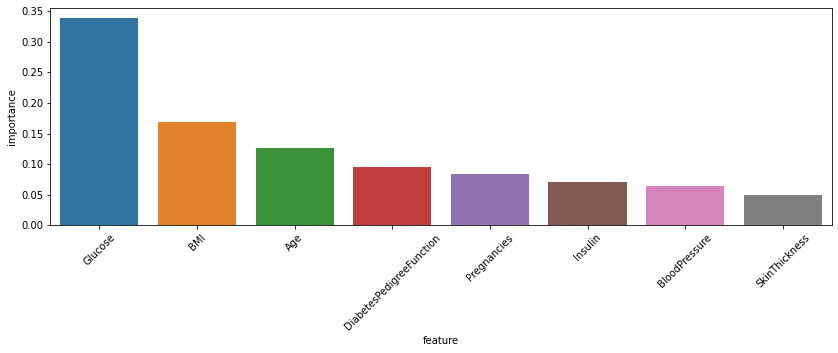

In [779]:
plt.figure(figsize=(14,4))
chart = sns.barplot(data=feature_importance, x='feature', y='importance')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

Novamente, vemos que `Glucose`, `BMI` e `Age` são variáveis importantes. 

Com esses modelos simples de ML temos uma acurácia melhor, mas nosso recall é significativamente menor. Mais tarde ajustaremos para otimizar o recall.

# Tratamento dos dados

Podemos limpar um pouco os dados antes de tentar modelos ML mais elaborados. Nessa seção, trataremos os dados faltantes e os outliers.

### Lidando com dados faltantes

Vamos comparar o SimpleImputer (testando média e mediana) e o KNNImputer.

In [780]:
# Testando SimpleImputer (mean)

sim_imp = SimpleImputer(strategy='mean')
std_scaler = StandardScaler()
log_clf = LogisticRegression()

treat_steps = [('imputer', sim_imp), ('scaler', std_scaler)]
treat_pipeline = Pipeline(treat_steps)
X_train_tr = treat_pipeline.fit_transform(X_train)

relatorio_cross_val(log_clf, X_train_tr, y_train)

Acurácia média: 0.7813 (std=0.0172)
Precisão média: 0.7388 (std=0.0511)
Recall médio: 0.5868 (std=0.0425)


In [781]:
# Testando SimpleImputer (median)

sim_imp = SimpleImputer(strategy='median')
std_scaler = StandardScaler()
log_clf = LogisticRegression()

treat_steps = [('imputer', sim_imp), ('scaler', std_scaler)]
treat_pipeline = Pipeline(treat_steps)
X_train_tr = treat_pipeline.fit_transform(X_train)

relatorio_cross_val(log_clf, X_train_tr, y_train)

Acurácia média: 0.7813 (std=0.0202)
Precisão média: 0.7387 (std=0.053)
Recall médio: 0.587 (std=0.0444)


In [782]:
# Testando KNNImputer

knn_imp = KNNImputer(n_neighbors=5)
std_scaler = StandardScaler()
log_clf = LogisticRegression()

treat_steps = [('imputer', knn_imp), ('scaler', std_scaler)]
treat_pipeline = Pipeline(treat_steps)
X_train_tr = treat_pipeline.fit_transform(X_train)

relatorio_cross_val(log_clf, X_train_tr, y_train)

Acurácia média: 0.783 (std=0.0117)
Precisão média: 0.7398 (std=0.038)
Recall médio: 0.5917 (std=0.058)


Vamos usar o tratamento do `KNNImputer`. Antes de prosseguir vamos analisar novamente os dados após o tratamento.

In [783]:
# Reconstruindo o dataframe

X_train_impute = pd.DataFrame(knn_imp.fit_transform(X_train), 
                              columns=X_train.columns, 
                              index=X_train.index)

X_train_impute.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
751,1.0,121.0,78.0,39.0,74.0,39.000000,0.261,28.0
358,12.0,88.0,74.0,40.0,54.0,35.299999,0.378,48.0
718,1.0,108.0,60.0,46.0,178.0,35.500000,0.415,24.0
536,0.0,105.0,90.0,28.0,152.2,29.600000,0.197,46.0
651,1.0,117.0,60.0,23.0,106.0,33.799999,0.466,27.0


In [784]:
def plot_dist_box(data, column):
    "Plota histograma e boxplot de uma coluna"
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(data=data, x=column, hue="Outcome", ax=ax[0])
    sns.boxplot(data=data, x=column, ax=ax[1])
    plt.show()

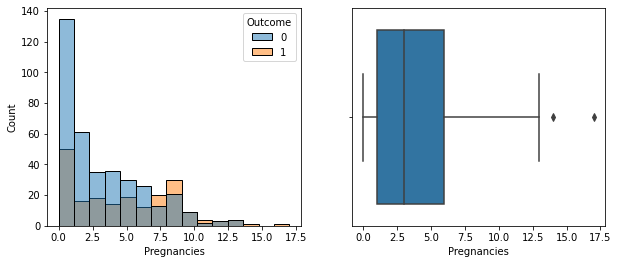

In [785]:
plot_dist_box(X_train_impute.join(y_train), "Pregnancies")

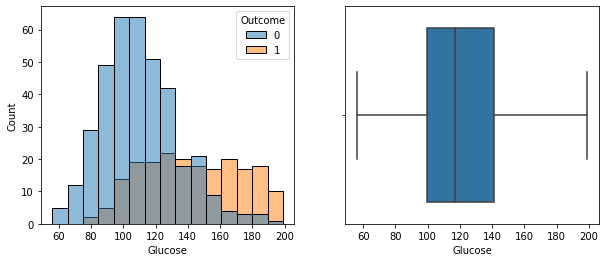

In [786]:
plot_dist_box(X_train_impute.join(y_train), "Glucose")

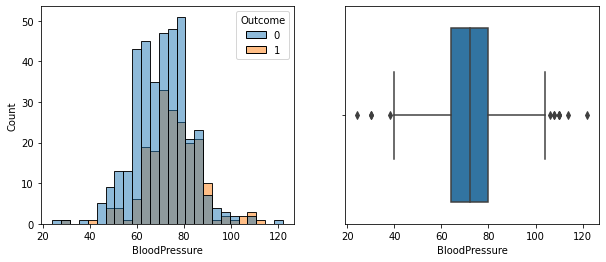

In [787]:
plot_dist_box(X_train_impute.join(y_train), "BloodPressure")

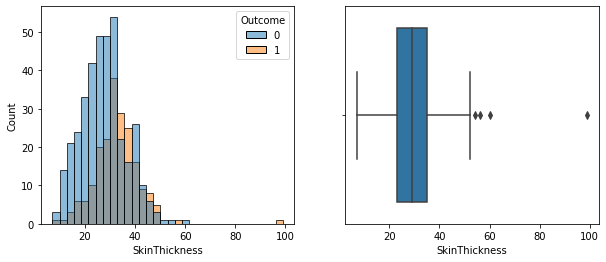

In [788]:
plot_dist_box(X_train_impute.join(y_train), "SkinThickness")

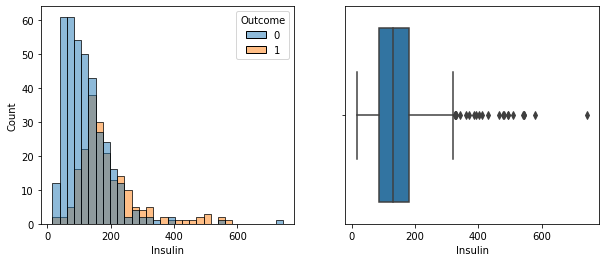

In [789]:
plot_dist_box(X_train_impute.join(y_train), "Insulin")

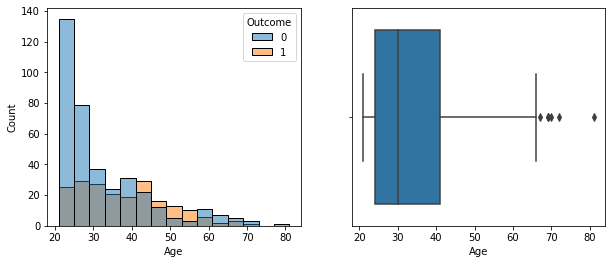

In [790]:
plot_dist_box(X_train_impute.join(y_train), "Age")

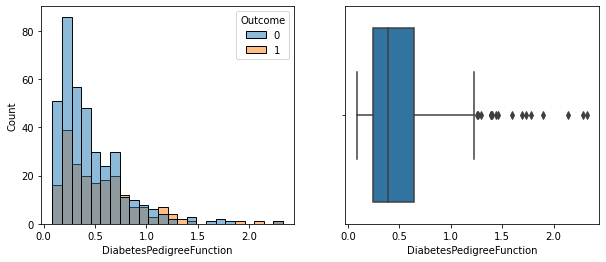

In [791]:
plot_dist_box(X_train_impute.join(y_train), "DiabetesPedigreeFunction")

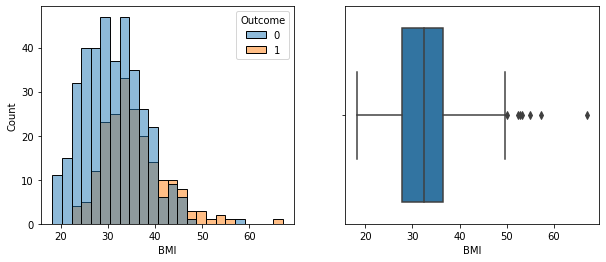

In [792]:
plot_dist_box(X_train_impute.join(y_train), "BMI")

Vamos verificar novamente a matriz de correlação.

In [793]:
corr_matrix = X_train_impute.join(y_train).corr()
print(corr_matrix["Outcome"].sort_values(ascending=False))

Outcome                     1.000000
Glucose                     0.510674
Insulin                     0.366798
BMI                         0.320818
SkinThickness               0.275669
Age                         0.239739
Pregnancies                 0.225421
BloodPressure               0.184984
DiabetesPedigreeFunction    0.151264
Name: Outcome, dtype: float64


 Nota-se que temos uma melhor correlação com o target.

### Tratando outliers

A distribuição da `DiabetesPedigreeFunction` e `Insulin` parecem muito inviesados. Aplicar um logaritmo torna ela mais normal:

In [794]:
X_train_log = X_train_impute.copy()

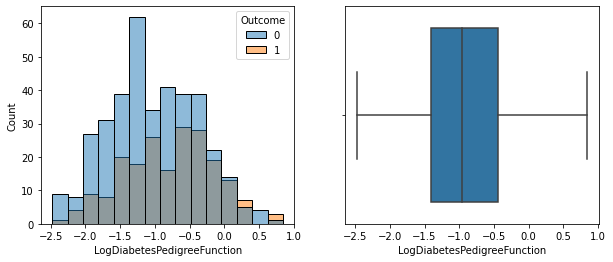

In [795]:
X_train_log['LogDiabetesPedigreeFunction'] = np.log(X_train_log['DiabetesPedigreeFunction'])
plot_dist_box(X_train_log.join(y_train), "LogDiabetesPedigreeFunction")

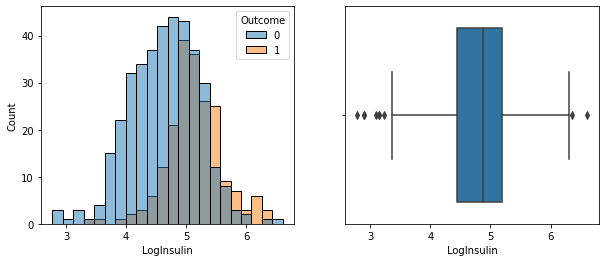

In [796]:
X_train_log['LogInsulin'] = np.log(X_train_log['Insulin'])
plot_dist_box(X_train_log.join(y_train), "LogInsulin")

In [797]:
correlacao(X_train_log.join(y_train))

Outcome                        1.000000
Glucose                        0.510674
LogInsulin                     0.404960
Insulin                        0.366798
BMI                            0.320818
SkinThickness                  0.275669
Age                            0.239739
Pregnancies                    0.225421
BloodPressure                  0.184984
LogDiabetesPedigreeFunction    0.164261
DiabetesPedigreeFunction       0.151264
Name: Outcome, dtype: float64


As distribuições parecem mais normais e as correlações melhoraram. Vamos verificar a performace. 

In [798]:
drop = ["Insulin", "DiabetesPedigreeFunction"]
X_train_log = X_train_log.drop(drop, axis=1)
X_train_log.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,Age,LogDiabetesPedigreeFunction,LogInsulin
751,1.0,121.0,78.0,39.0,39.000000,28.0,-1.343235,4.304065
358,12.0,88.0,74.0,40.0,35.299999,48.0,-0.972861,3.988984
718,1.0,108.0,60.0,46.0,35.500000,24.0,-0.879477,5.181784
536,0.0,105.0,90.0,28.0,29.600000,46.0,-1.624552,5.025195
651,1.0,117.0,60.0,23.0,33.799999,27.0,-0.763570,4.663439


In [799]:
log_clf = LogisticRegression()

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_log)

log_clf.fit(X_train_sc, y_train)
relatorio_cross_val(log_clf, X_train_sc, y_train)

Acurácia média: 0.7761 (std=0.0147)
Precisão média: 0.7198 (std=0.0262)
Recall médio: 0.5917 (std=0.0766)


Apesar das correlações melhorarem, nosso modelo teve uma performace pior. Vamos seguir sem esse tratamento.

### Binning

Vamos tentar agora agrupar dados para reduzir o ruído de alguma feature. Como discutido, fazer esse tratamento isso na `Age` talvez ajude nosso modelo. 

In [800]:
X_train_bins = X_train_impute.copy()
X_train_bins.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
751,1.0,121.0,78.0,39.0,74.0,39.000000,0.261,28.0
358,12.0,88.0,74.0,40.0,54.0,35.299999,0.378,48.0
718,1.0,108.0,60.0,46.0,178.0,35.500000,0.415,24.0
536,0.0,105.0,90.0,28.0,152.2,29.600000,0.197,46.0
651,1.0,117.0,60.0,23.0,106.0,33.799999,0.466,27.0


Usaremos `KBinsDiscretizer`:

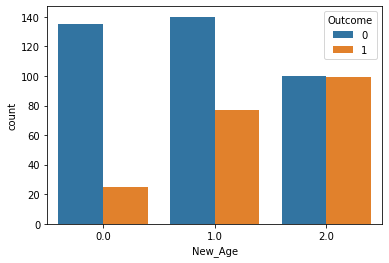

In [801]:
kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
X_train_bins["New_Age"] = kbins.fit_transform(X_train_bins[['Age']])

sns.countplot(data=X_train_bins.join(y_train), x="New_Age", hue='Outcome');

In [802]:
correlacao(X_train_bins.join(y_train))

Outcome                     1.000000
Glucose                     0.510674
Insulin                     0.366798
BMI                         0.320818
New_Age                     0.279655
SkinThickness               0.275669
Age                         0.239739
Pregnancies                 0.225421
BloodPressure               0.184984
DiabetesPedigreeFunction    0.151264
Name: Outcome, dtype: float64


In [803]:
# Testando o binning com regressão logística

X_train_bins = X_train_bins.drop('Age', axis=1)
log_clf = LogisticRegression()

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_bins)

log_clf.fit(X_train_sc, y_train)
relatorio_cross_val(log_clf, X_train_sc, y_train)

Acurácia média: 0.783 (std=0.0191)
Precisão média: 0.7412 (std=0.0613)
Recall médio: 0.5967 (std=0.0394)


O tratamento é semelhante à uma condificação por faixa etária (criança, jovem, adulto, idoso). Temos resultados semelhantes, mas simplificamos nosso modeloi. Seguiremos com esse tratamento.

## Quantile Scaling

`BMI` parece ser uma feature importante, mas talvez precise ser ajustada e seus outliers tratados. Vamos testar um QuantileTransformer.

In [804]:
X_train_scaling = X_train_bins.copy()
X_train_scaling.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,New_Age
751,1.0,121.0,78.0,39.0,74.0,39.000000,0.261,1.0
358,12.0,88.0,74.0,40.0,54.0,35.299999,0.378,2.0
718,1.0,108.0,60.0,46.0,178.0,35.500000,0.415,0.0
536,0.0,105.0,90.0,28.0,152.2,29.600000,0.197,2.0
651,1.0,117.0,60.0,23.0,106.0,33.799999,0.466,1.0


In [805]:
qt = QuantileTransformer(n_quantiles=3, random_state=42)
X_train_scaling[['New_BMI']] = qt.fit_transform(X_train_scaling[['BMI']])

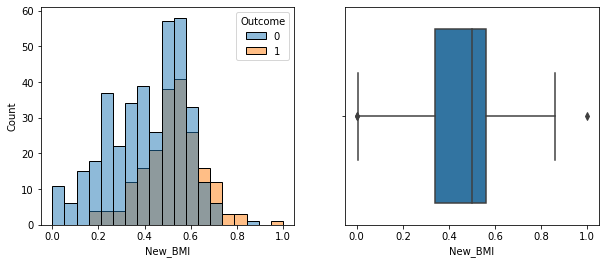

In [806]:
plot_dist_box(X_train_scaling.join(y_train), "New_BMI")

In [807]:
# Testando o QuantileTransformer

X_train_scaling = X_train_scaling.drop('BMI', axis=1)

log_clf = LogisticRegression()

std_scaler = StandardScaler()
X_train_sc = std_scaler.fit_transform(X_train_scaling)

log_clf.fit(X_train_sc, y_train)
relatorio_cross_val(log_clf, X_train_sc, y_train)

Acurácia média: 0.7865 (std=0.0159)
Precisão média: 0.7423 (std=0.0466)
Recall médio: 0.6017 (std=0.044)


Essa transformação nos rendeu um bom resultado. Vamos seguir com ela.

In [846]:
# Pipeline final de tratamento

knn_imp = KNNImputer(n_neighbors=5)
kbins = KBinsDiscretizer(n_bins=3, encode='ordinal')
qt = QuantileTransformer(n_quantiles=3, random_state=42)
std_scaler = StandardScaler()

ct = ColumnTransformer([('kbins_Age', kbins, [7]), ('qt_BMI', qt, [5])], remainder='passthrough')

steps = [('imputer', knn_imp), 
         ('kbins', kbins_age),
         ('scaler', std_scaler),
        ]

treatment_pipeline = Pipeline(steps)

## Modelos finais

In [847]:
# Aplicando a pipeline ao treino
X_train_tr = treatment_pipeline.fit_transform(X_train)

### Logistic regression

In [848]:
log_clf = LogisticRegression()
log_clf.fit(X_train_tr, y_train)
relatorio_cross_val(log_clf, X_train_tr, y_train)

Acurácia média: 0.7865 (std=0.0159)
Precisão média: 0.7423 (std=0.0466)
Recall médio: 0.6017 (std=0.044)


## Random Forest

In [811]:
# # Randomized Search CV para a Random Forest

# forest_clf = RandomForestClassifier(max_depth=5, max_features=4, 
#                                     min_samples_split=30, n_estimators=500, 
#                                     random_state=42)

# params_grid = {"n_estimators":np.linspace(100,1000,10, dtype=np.int), 
#                "max_depth":np.arange(4, 21, 1, dtype=np.int),
#                "min_samples_split": [2,5,10,30],
#                "max_features": [3,4,5,6,7]
#               }
# forest_randcv = RandomizedSearchCV(forest_clf, params_grid, n_iter=100, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
# forest_randcv.fit(X_train_tr, y_train)

# print(f'Melhor estimador:{forest_randcv.best_params_}')
# relatorio_cross_val(forest_randcv.best_estimator_, X_train_tr, y_train)

In [812]:
# Vamos reservar um modelo treinado para fazer um ensemble

forest_clf = RandomForestClassifier(max_depth=15, 
                                    max_features=5, 
                                    min_samples_split=2, 
                                    n_estimators=200, 
                                    random_state=42)

forest_clf.fit(X_train_tr, y_train)
relatorio_cross_val(forest_clf, X_train_tr, y_train)

Acurácia média: 0.7622 (std=0.0256)
Precisão média: 0.6863 (std=0.0438)
Recall médio: 0.5967 (std=0.0938)


### XGBoost

In [813]:
# # Randomized Search CV para a XGBoost

# xgb_clf = XGBClassifier(learning_rate=0.07, max_depth=6, n_estimators=500, random_state=42)

# params_grid = {"n_estimators":np.linspace(100,1000,10, dtype=np.int), 
#                "max_depth":np.arange(4, 21, 1, dtype=np.int),
#                "learning_rate": np.linspace(0,1,11)
#               }
# xgb_randcv = RandomizedSearchCV(xgb_clf, params_grid, n_iter=100, cv=3, scoring='accuracy', verbose=3, n_jobs=-1)
# xgb_randcv.fit(X_train_tr, y_train)

# print(f'Melhor estimador:{xgb_randcv.best_params_}')
# relatorio_cross_val(xgb_randcv.best_estimator_, X_train_tr, y_train)

In [814]:
# Grid Search CV para XGB

# params = {
#     "learning_rate": [0.06, 0.09, 0.1, 0.2],
#     "max_depth":[4,5,6,7,8],
#     "n_estimators":[100,200,500]}

# grid_search_cv = GridSearchCV(xgb_clf, params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
# grid_search_cv.fit(X_train, y_train)
# grid_search_cv.best_estimator_
# grid_search_cv.best_score_

In [815]:
# Vamos reservar um modelo treinado para fazer um ensemble

xgb_clf = XGBClassifier(learning_rate=0.4, 
                        max_depth=10, 
                        n_estimators=800,
                        random_state=42)

xgb_clf.fit(X_train_tr, y_train)
relatorio_cross_val(xgb_clf, X_train_tr, y_train)

Acurácia média: 0.7309 (std=0.014)
Precisão média: 0.6249 (std=0.0168)
Recall médio: 0.5721 (std=0.0489)


## Support-vector machine

In [834]:
svc_clf = SVC(kernel='linear', C=1.0, probability=True)
svc_clf.fit(X_train_tr, y_train)
relatorio_cross_val(svc_clf, X_train_tr, y_train)

Acurácia média: 0.7813 (std=0.0099)
Precisão média: 0.7421 (std=0.0341)
Recall médio: 0.5768 (std=0.038)


### Majority hard vote 

In [817]:
estimators = [('forest', forest_clf), ('xgb', xgb_clf), ('svc', svc_clf), ('log', log_clf)]
voting_hard_clf = VotingClassifier(estimators, voting='hard')
voting_hard_clf.fit(X_train_tr, y_train)
relatorio_cross_val(voting_hard_clf, X_train_tr, y_train)

Acurácia média: 0.7691 (std=0.017)
Precisão média: 0.7398 (std=0.0364)
Recall médio: 0.527 (std=0.0778)


### Majority soft vote 

In [818]:
estimators = [('forest', forest_clf), ('xgb', xgb_clf), ('svc', svc_clf), ('log', log_clf)]
voting_soft_clf = VotingClassifier(estimators, voting='soft')
voting_soft_clf.fit(X_train_tr, y_train)
relatorio_cross_val(voting_soft_clf, X_train_tr, y_train)

Acurácia média: 0.7657 (std=0.0178)
Precisão média: 0.6994 (std=0.0397)
Recall médio: 0.5866 (std=0.0803)


## Avaliação final do modelo

In [849]:
X_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
635,13,104.0,72.0,NaN,NaN,31.200001,0.465,38
698,4,127.0,88.0,11.0,155.0,34.500000,0.598,28
637,2,94.0,76.0,18.0,66.0,31.600000,0.649,23
402,5,136.0,84.0,41.0,88.0,35.000000,0.286,35
425,4,184.0,78.0,39.0,277.0,37.000000,0.264,31


In [850]:
# Tratamento dos dados de teste

X_test_tr = treatment_pipeline.transform(X_test)

In [851]:
def metrics_report(y_train, y_pred):
    accuracy = np.round(accuracy_score(y_train, y_pred), 4)
    precision = np.round(precision_score(y_train, y_pred), 4)
    recall = np.round(recall_score(y_train, y_pred), 4)
    print(f"Accuracy score: {accuracy}")
    print(f"Precision score: {precision}")
    print(f"Recall score: {recall}")
    print("-------------------------- \n")

In [852]:
models = [forest_clf, xgb_clf, svc_clf, log_clf, voting_hard_clf, voting_soft_clf]
models_names = ["Random Forest", "XGBoost", "SVM", "Log. Reg.", "Hard voting", "Soft voting"]

for name, model in zip(models_names, models):
    y_pred = model.predict(X_test_tr)
    print(f"*Results for {name} \n")
    metrics_report(y_test, y_pred)

*Results for Random Forest 

Accuracy score: 0.724
Precision score: 0.6207
Recall score: 0.5373
-------------------------- 

*Results for XGBoost 

Accuracy score: 0.7396
Precision score: 0.6308
Recall score: 0.6119
-------------------------- 

*Results for SVM 

Accuracy score: 0.6354
Precision score: 0.4789
Recall score: 0.5075
-------------------------- 

*Results for Log. Reg. 

Accuracy score: 0.724
Precision score: 0.625
Recall score: 0.5224
-------------------------- 

*Results for Hard voting 

Accuracy score: 0.724
Precision score: 0.6458
Recall score: 0.4627
-------------------------- 

*Results for Soft voting 

Accuracy score: 0.7344
Precision score: 0.6333
Recall score: 0.5672
-------------------------- 



# Conclusões

In [823]:
# Curva e ajuste recall-precisão
# Curva ROC
# Métricas

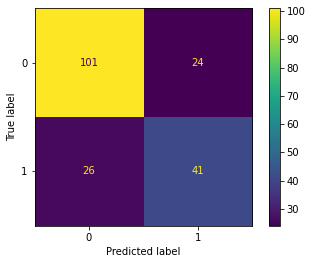

In [857]:
cm_ml = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm_ml).plot();

In [863]:
# Ajuste de precisão/recall

from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(log_clf, X_test_tr, y_test, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

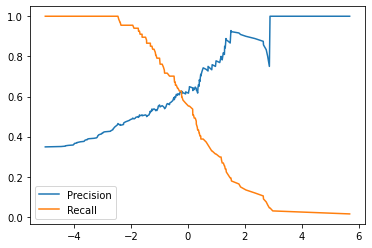

In [864]:
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.legend()
plt.show()

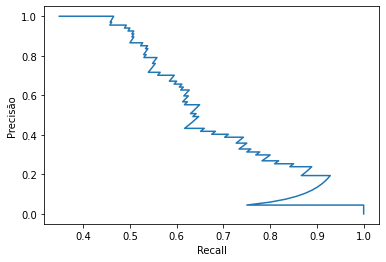

In [865]:
plt.plot(precisions, recalls)
plt.ylabel('Precisão')
plt.xlabel('Recall')
plt.show()

In [829]:
# Redução de dimensão
# Avaliar matriz de confusão e impacto financeiro do modelo